In [18]:
import frgtools.misc as frgm
import frgtools.jv as jv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
import os
from scipy.optimize import curve_fit
from tqdm import tqdm
import seaborn as sns
import frgtools.misc as frgm

# Loading Raw Data File

In [19]:
fids = frgm.listdir('Data')

Files in 'Data':
0:20200312_Optimization.txt
1:20191113_beamlinecontrol.txt
2:20191121_MC_ITO.txt
3:20191031_PMMA_P3HT_InterlayerThicknessStudy.txt
4:20191010_Thickness_Study.txt
5:20200312_Optimization.csv
6:20191120_MC_ITO.txt
7:20191121_DPPDTT.txt
8:20190822_CsFa_Baseline_Attempt.txt
9:20190930_HTL_Study_thinAU.txt
10:20200211_Module1__curve.txt
11:20190930_HTL_Study_THICKAU.txt


In [11]:
# fids = []
# for f in frgm.listdir('Data', display = False):
#     if 'control' in f and '_rgb' not in f:
#         continue
#     fids.append(f)
# fids

In [31]:
# Use either frgm tool to load the file path or replace "fids[0]" with your file path
# use regular csv read if you converted to csv
# df = pd.read_csv(fids[1], header=None) 
# otherwise use:
df = pd.read_csv(fids[0], delimiter="\t", header=None)
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
row, col = df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Columns: 555 entries, 0 to 554
dtypes: object(555)
memory usage: 698.2+ KB


# Converting Raw Data to Dataframe

In [32]:
Device = []
for n in range(1, col,3):
    Device.append(df.iloc[1,n])
    
Run = []
for n in range(1, col,3):
    Run.append(df.iloc[0,n])

Size = []
for n in range(1, col,3):
    Size.append(df.iloc[3,n])

Date = []
for n in range(1, col,3):
    Date.append(df.iloc[6,n])

Time = []
for n in range(1, col,3):
    Time.append(df.iloc[7,n])
    
Type = []
for n in range(1, col,3):
    Type.append(df.iloc[2,n])

data_tuples = list(zip(Device, Run, Type, Size, Date, Time))
    
Tracer = pd.DataFrame(data_tuples, columns=['Device','Run','Type','Size', 'Date', 'Time'])

Tracer["Voltage_string"] = np.nan
Tracer["Current_string"] = np.nan
Tracer["Power_string"] = np.nan
Tracer["Voltage"] = np.nan
Tracer["Current"] = np.nan
Tracer["Power"] = np.nan
Tracer["PCE"] = np.nan
Tracer["FF"] = np.nan
Tracer["Jsc"] = np.nan
Tracer["Voc"] = np.nan
Tracer["Vmpp"] = np.nan

In [33]:
# Converting to object to hold arrays in a single cell
Tracer = Tracer.astype('object')

In [34]:
# Size gathering
row1, col1 = Tracer.shape

In [35]:
for n in range(0, col,3):
    Tracer.at[n/3,'Voltage_string']=df[n][12:].values.tolist()

for n in range(1, col,3):
    Tracer.at[(n-1)/3,'Current_string']=df[n][12:].values.tolist()
    
for n in range(2, col,3):
    Tracer.at[(n-2)/3,'Power_string']=df[n][12:].values.tolist()

#removing dark curves
Tracer=Tracer.dropna(subset=['Run'], how='any')
Tracer.reset_index(drop=True, inplace=True)
row1, col1 = Tracer.shape

# Looping the Curve Fitting Over Each Measurement

In [36]:
for n in range(0, row1, 1):
    Tracer.at[n,'Voltage'] = np.array(Tracer.loc[n,'Voltage_string'], dtype=np.float32)
    Tracer.at[n,'Current'] = np.array(Tracer.loc[n,'Current_string'], dtype=np.float32)
    Tracer.at[n,'Power'] = np.array(Tracer.loc[n,'Power_string'], dtype=np.float32)
    
Tracer = Tracer.drop(['Voltage_string', 'Current_string', 'Power_string'], axis=1)

for t in tqdm(range(0, row1, 1)):
    try:
        temp_dict = jv.FitLight(Tracer.loc[t]['Voltage'], Tracer.loc[t]['Current'], np.float(Tracer.loc[t]['Size']), diodes = 2, plot = False, init_guess = {}, bounds = {}, maxfev = 5000, type = None)
        temp_list = list(temp_dict.values()) 
        Tracer.at[t,'Voc']= temp_list[7]*1000
        Tracer.at[t,'Jsc']= temp_list[8]*1000
        Tracer.at[t,'Vmpp']= temp_list[9]*1000
        Tracer.at[t,'PCE']= temp_list[10]*100
        Tracer.at[t,'FF']= temp_list[11]*100
    except:
        print('line   ' + str(t) + '   is erroneous')
        pass
print('the rest should be ok')
# Really bad devices, and bugged measurements will give errors

 25%|██▌       | 34/134 [00:00<00:01, 61.93it/s]

Current seems too high (max = 0.053819987390722544 mA/cm2). Please double check that your area (cm2) and measured current (A) are correct.
Current seems too high (max = 0.0543927341433508 mA/cm2). Please double check that your area (cm2) and measured current (A) are correct.


 87%|████████▋ | 117/134 [00:01<00:00, 68.95it/s]/opt/anaconda3/envs/ds/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 134/134 [00:01<00:00, 67.87it/s]

Current seems too high (max = 0.05231439801199095 mA/cm2). Please double check that your area (cm2) and measured current (A) are correct.
Current seems too high (max = 0.07167602889239788 mA/cm2). Please double check that your area (cm2) and measured current (A) are correct.
Current seems too high (max = 0.05036164075136184 mA/cm2). Please double check that your area (cm2) and measured current (A) are correct.
line   124   is erroneous
line   126   is erroneous
line   128   is erroneous
line   131   is erroneous
line   133   is erroneous
the rest should be ok


## Quick Summary Statistics

In [37]:
stats_table1 = Tracer[['PCE', 'FF', 'Jsc', 'Voc', 'Vmpp']]
stats_table1=stats_table1.astype(str).astype(float)
stats_table1.describe()

,PCE,FF,Jsc,Voc,Vmpp
count,129.000000,129.000000,129.000000,129.000000,129.000000
mean,9.655489,67.508932,19.195519,763.146146,601.205679
std,5.189053,83.521173,4.524168,340.119476,266.944780
min,0.008766,26.240402,0.054464,7.673089,6.501638
25%,6.285927,41.993137,19.313435,566.783547,532.776952
50%,10.578673,57.527693,20.981394,941.652417,710.177779
75%,13.781789,68.145395,21.497187,996.992707,794.124663
max,17.111892,838.740103,22.416978,1044.183493,939.388216


In [38]:
Tracer.to_csv('file_name.csv')

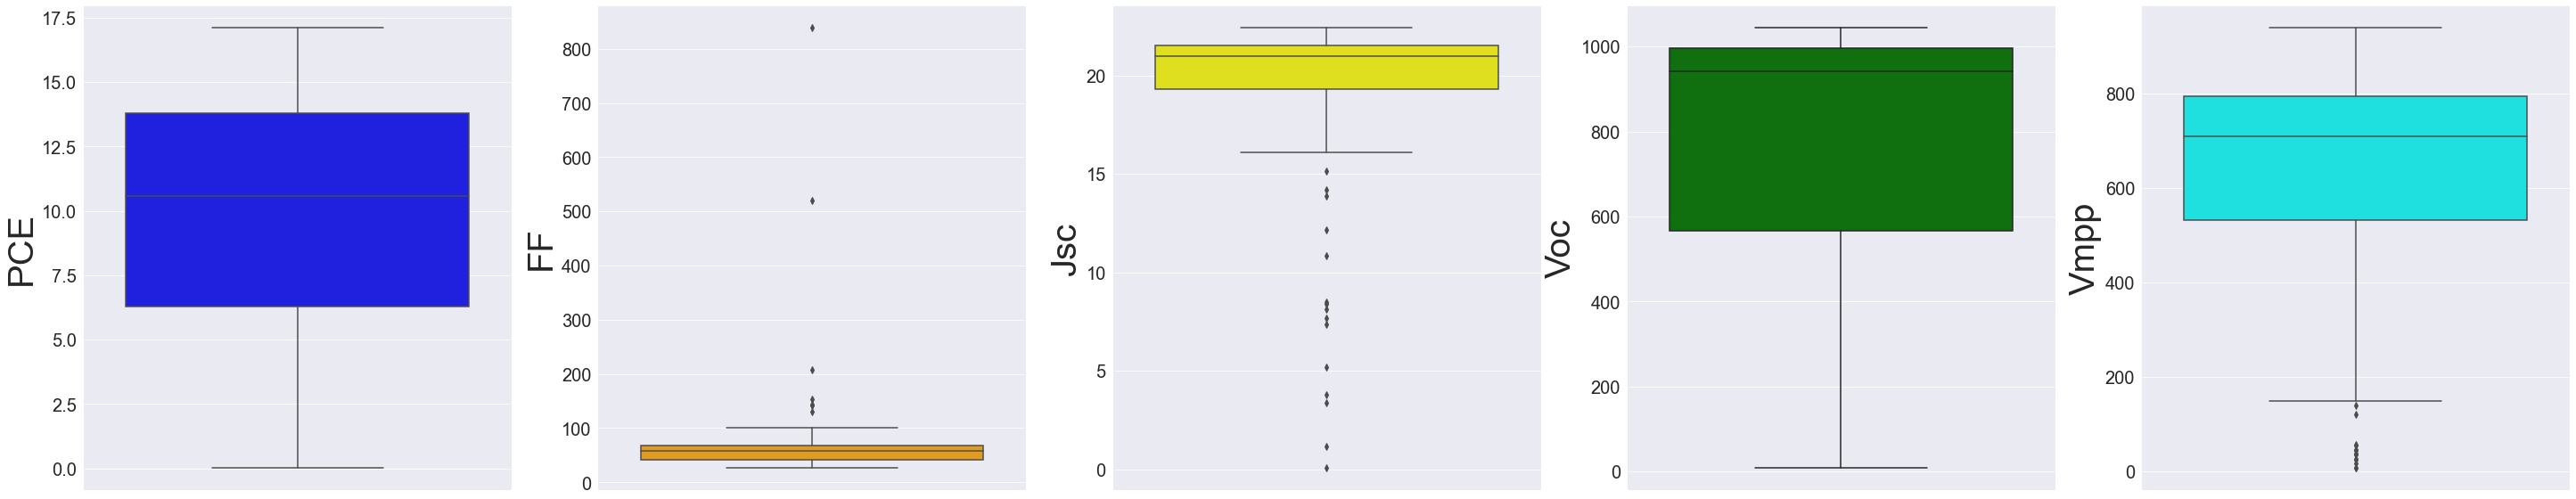

In [39]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# stats_table.hist(bins=5, figsize=(7,10)) # a quick and dirty histogram

mpl.rc('axes', labelsize=40)
mpl.rc('xtick', labelsize=30)
mpl.rc('ytick', labelsize=20)
f, axes = plt.subplots(1, 5, figsize=(50,10))
sns.set_style("darkgrid")
sns.boxplot(stats_table1['PCE'],  orient='v' , ax=axes[0], color="blue")
sns.boxplot(stats_table1['FF'],  orient='v' , ax=axes[1], color="orange")
sns.boxplot(stats_table1['Jsc'],  orient='v' , ax=axes[2], color="yellow")
sns.boxplot(stats_table1['Voc'],  orient='v' , ax=axes[3], color="green")
sns.boxplot(stats_table1['Vmpp'],  orient='v' , ax=axes[4], color = "cyan")
plt.show()

# Creating a Subset Dataframe

In [40]:
# Filtering out nonsensical FF
Tracer = Tracer[Tracer['FF'] < 100]  

# Filtering out failed devices
Tracer = Tracer[Tracer['PCE'] > 5]  

# Filtering out bugged curves (manual entry)
Tracer = Tracer[Tracer.Device != 'C5SASD1_P3_S1']
Tracer = Tracer[Tracer.Device != 'C9SASD2_P2_S2']
Tracer = Tracer[Tracer.Device != 'C9EASD1_P3_S1']
Tracer = Tracer[Tracer.Device != 'C5EASD1_P2_S1']
Tracer = Tracer[Tracer.Device != 'C9SASD1_P2_S1']
Tracer = Tracer[Tracer.Device != 'C5SASD2_P3_S1']
Tracer = Tracer[Tracer.Device != 'C9SASD2_P1_S1']

# Reseting index in master dataframe for clarity
Tracer.reset_index(drop=True, inplace=True)

# plotting a subset of experiment
filter_1 = "9"
filter_2 = "SASD"
filter_3 = "2" #scan direction , depends on measurement setting


df_filter1 = Tracer[Tracer.Device.str.contains(filter_1)]
df_filter2 = df_filter1[df_filter1.Device.str.contains(filter_2)]
df_filter3 = df_filter2[df_filter2.Type.str.contains(filter_3)]
df_filter3.reset_index(drop=True, inplace=True)

# observing your dataset before plotting
df_filter3.head()

,Device,Run,Type,Size,Date,Time,Voltage,Current,Power,PCE,FF,Jsc,Voc,Vmpp
0,C9SASD1_P3_S1,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:29:40 PM,"[-0.20107022, -0.19645989, -0.18471336, -0.175...","[0.0015316143, 0.0015280311, 0.0015303666, 0.0...","[-0.00030796204, -0.0003001968, -0.00028267916...",17.1119,75.4215,21.9371,1034.25,861.504
1,C9SASD1_P3_S2,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:30:17 PM,"[-0.20356321, -0.1966825, -0.18516052, -0.1757...","[0.0015044122, 0.0015053173, 0.0015048028, 0.0...","[-0.000306243, -0.00029606954, -0.00027863006,...",15.2561,70.4663,21.4979,1007.09,814.556
2,C9SASD2_P1_S2,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:34:58 PM,"[-0.21481754, -0.20019059, -0.19388454, -0.184...","[0.0016130671, 0.0016001149, 0.0015930269, 0.0...","[-0.00034651512, -0.00032032793, -0.0003088632...",11.7836,55.4981,21.5052,987.318,747.763
3,C9SASD2_P2_S3,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:35:59 PM,"[-0.2130143, -0.20346706, -0.1947258, -0.18470...","[0.001607443, 0.0015953957, 0.0015877527, 0.00...","[-0.00034240834, -0.00032461045, -0.0003091764...",12.2328,57.9217,21.5886,978.27,710.893
4,C9SASD2_P3_S1,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:36:19 PM,"[-0.21416849, -0.20286454, -0.19490713, -0.185...","[0.0016619107, 0.0016456845, 0.0016313442, 0.0...","[-0.00035592887, -0.00033385103, -0.0003179606...",8.413,45.6138,21.0534,876.057,588.898


## Summary Statistics 

In [41]:
stats_table2 = df_filter3[['PCE', 'FF', 'Jsc', 'Voc', 'Vmpp']]
stats_table2=stats_table2.astype(str).astype(float)
stats_table2.describe()

,PCE,FF,Jsc,Voc,Vmpp
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,12.850978,60.619165,21.494314,976.999501,743.581712
std,3.015018,10.752393,0.286956,53.821919,93.796131
min,8.412999,45.613801,21.053402,876.056910,588.898480
25%,11.895897,56.104000,21.412256,978.457123,717.638746
50%,12.270611,58.357661,21.501542,983.168095,742.819279
75%,14.519227,67.548105,21.567733,1002.145916,797.857448
max,17.111892,75.421501,21.937105,1034.245253,861.504495


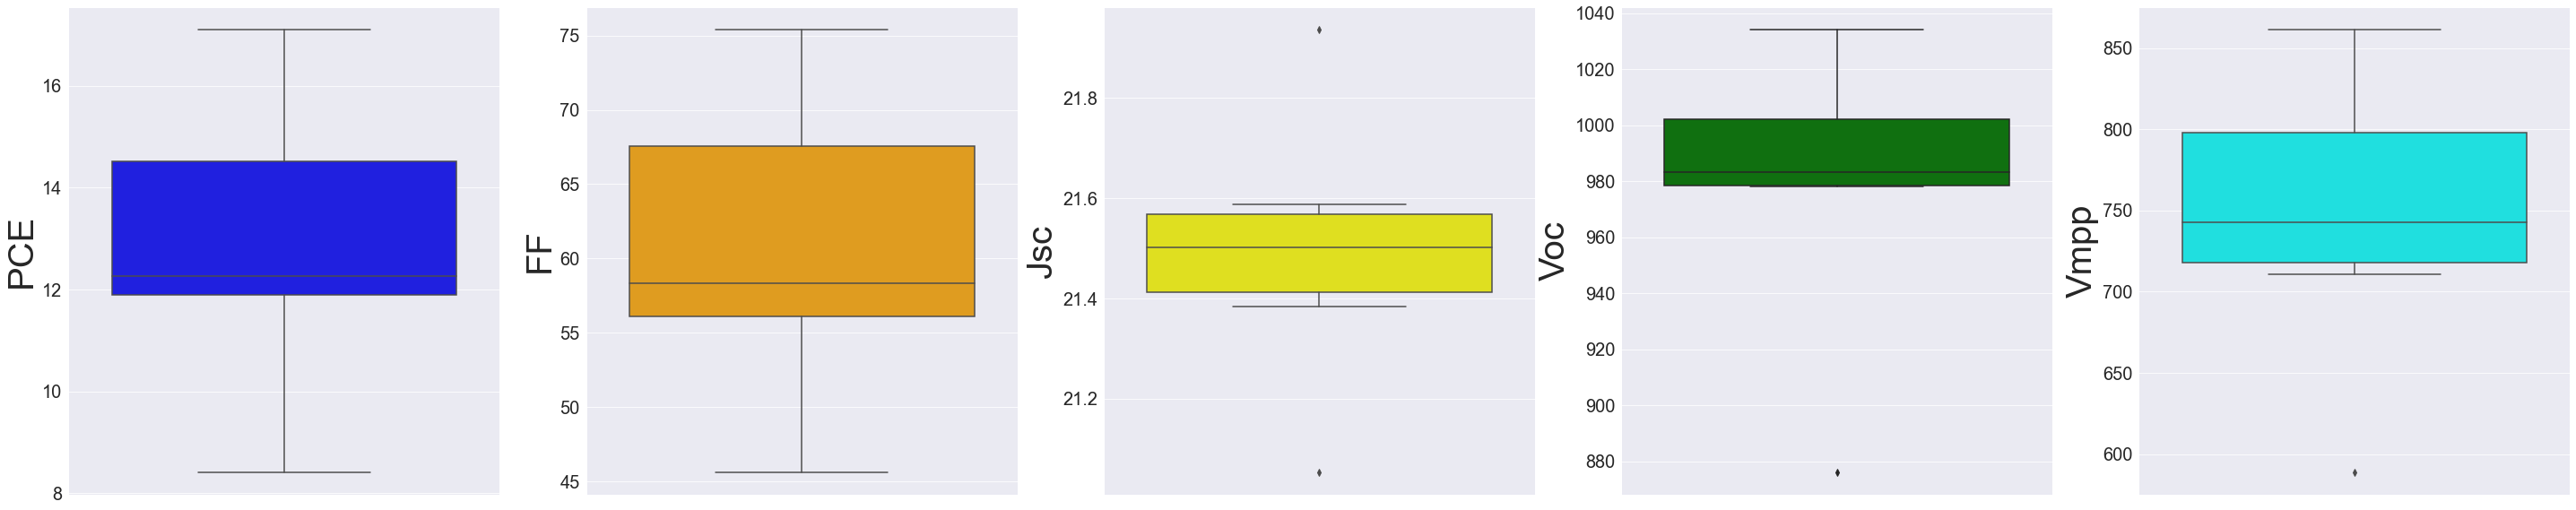

In [42]:
mpl.rc('axes', labelsize=40)
mpl.rc('xtick', labelsize=30)
mpl.rc('ytick', labelsize=20)
f, axes = plt.subplots(1, 5, figsize=(50,10))
sns.set_style("darkgrid")
sns.boxplot(stats_table2['PCE'],  orient='v' , ax=axes[0], color="blue")
sns.boxplot(stats_table2['FF'],  orient='v' , ax=axes[1], color="orange")
sns.boxplot(stats_table2['Jsc'],  orient='v' , ax=axes[2], color="yellow")
sns.boxplot(stats_table2['Voc'],  orient='v' , ax=axes[3], color="green")
sns.boxplot(stats_table2['Vmpp'],  orient='v' , ax=axes[4], color = "cyan")
plt.show()

# Plotting the Subset

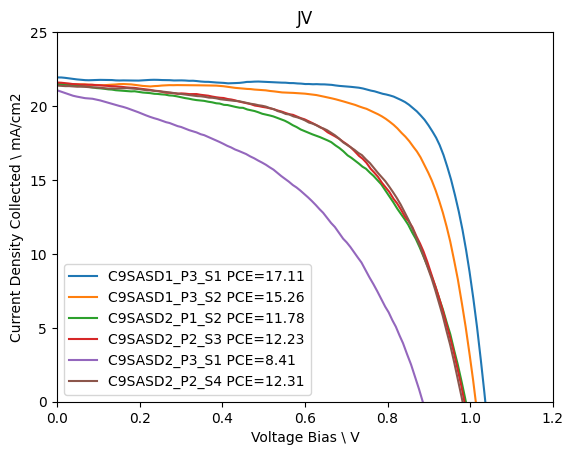

In [43]:
# filtered DataFrame to Plot
DF = df_filter3 

mpl.rcParams.update(mpl.rcParamsDefault)

for q in range (0, len(DF), 1):

    plt.plot(DF.loc[q]['Voltage'],DF.loc[q]['Current']/np.float(DF.loc[q]['Size'])*1000, label=DF.loc[q]['Device']+ ' PCE='+ str(round(DF.loc[q]['PCE'],2)))
#     plt.plot(DF.loc[q]['Voltage'],DF.loc[q]['Power']/np.float(DF.loc[q]['Size'])*1000, label=DF.loc[q]['Device']+' '+'Power Curve')

plt.legend()
plt.title('JV')
plt.ylim(0,25)
plt.xlim(0,1.2)

plt.ylabel('Current Density Collected \ mA/cm2')
plt.xlabel('Voltage Bias \ V')
plt.show()